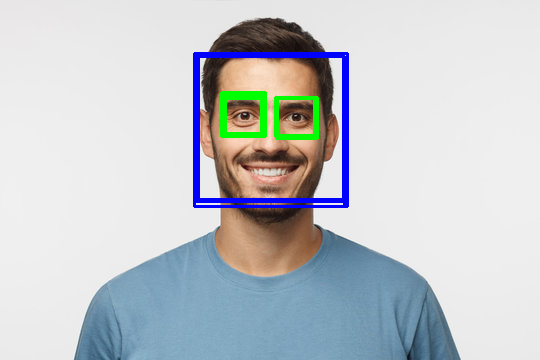

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/content/haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!wget https://github.com/AvivSham/German-Traffic-Signs-Classification/blob/master/signnames.csv

--2024-07-11 10:09:52--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 3.160.244.127, 3.160.244.136, 3.160.244.23, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|3.160.244.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  37.3MB/s    in 3.5s    

2024-07-11 10:09:57 (33.6 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

--2024-07-11 10:09:57--  https://github.com/AvivSham/German-Traffic-Signs-Classification/blob/master/signnames.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘signnames.c

In [3]:
!unzip traffic-signs-data.zip

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [4]:
import keras
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras import backend as K
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import csv
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import warnings
from skimage import exposure
import pickle
plt.style.library['ggplot']
%config InlineBackend.figure_format='retina'
import os, pickle, shutil

In [5]:
%matplotlib inline
import os, pickle, shutil
import numpy as np
from skimage.io import imread
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import confusion_matrix
import csv
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras import optimizers
from keras.initializers import random_normal
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sn
from sklearn.metrics import confusion_matrix

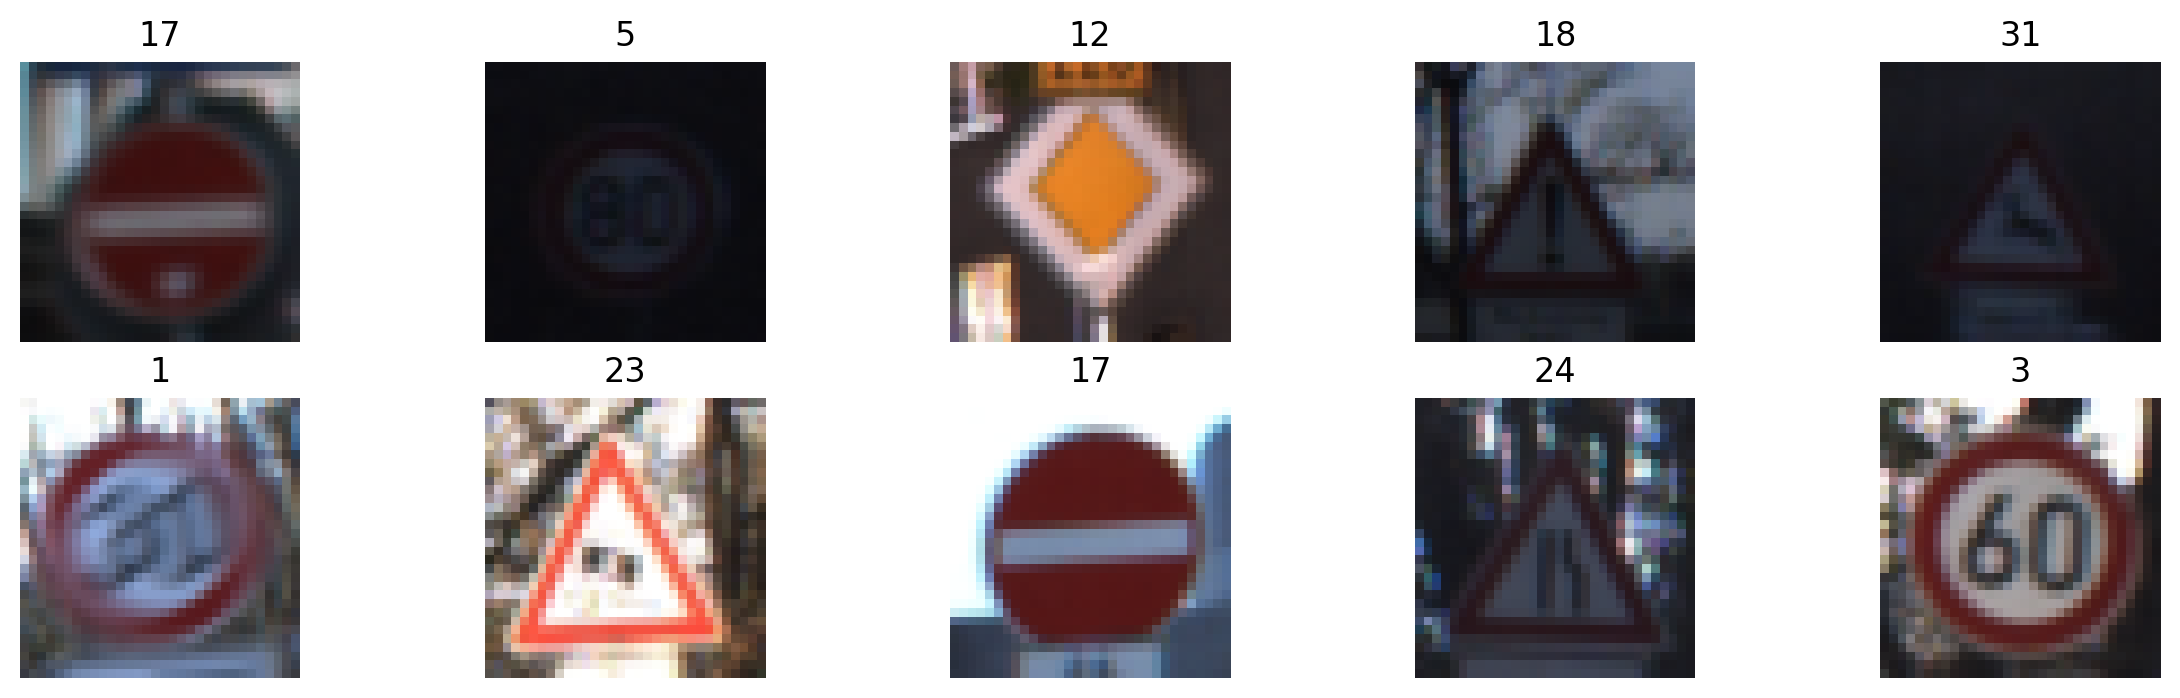

In [6]:
training_file = '/content/train.p'
testing_file = '/content/test.p'

with open (training_file, mode='rb') as f:
  train = pickle.load(f)
with open (testing_file, mode='rb') as f:
  test = pickle.load(f)
X,y=train['features'],train['labels']
X_train,X_valid,y_train,y_valid=train_test_split(X,y,stratify=y,test_size=4000,random_state=0)
X_test,y_test=test['features'],test['labels']
figure,axiss=plt.subplots(2,5,figsize=(15,4))
figure.subplots_adjust(hspace=.2,wspace=.001)
axiss=axiss.ravel()
for i in range(10):
  index=random.randint(0,len(X_train))
  image=X_train[index]
  axiss[i].axis('off')
  axiss[i].imshow(image)
  axiss[i].set_title(y_train[index])

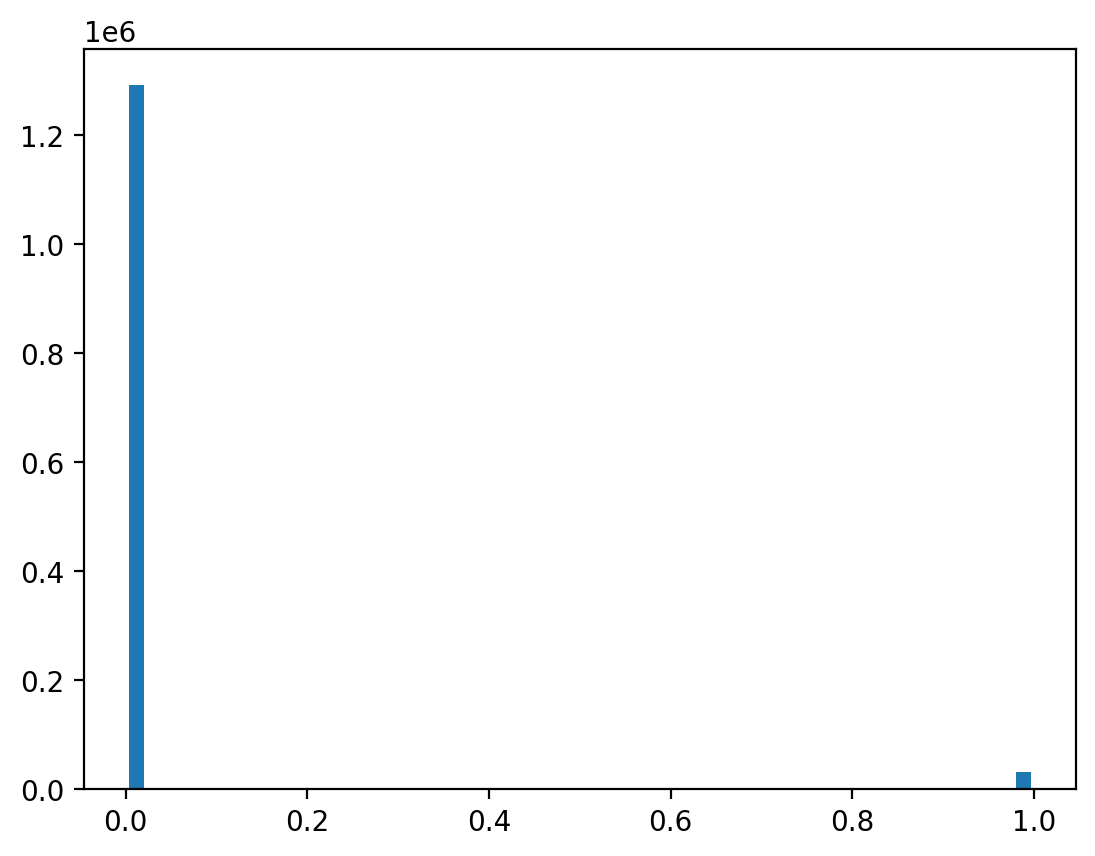

In [35]:
image_rows,image_cols=32,32
batch_size=256
num_classes=43
epochs=10
histogram,the_bins=np.histogram(y_train,bins=num_classes)
the_width=0.7*(the_bins[1]-the_bins[0])
center=(the_bins[:-1]+the_bins[1:])/2
plt.bar(center,histogram,align='center',width=the_width)
plt.show()

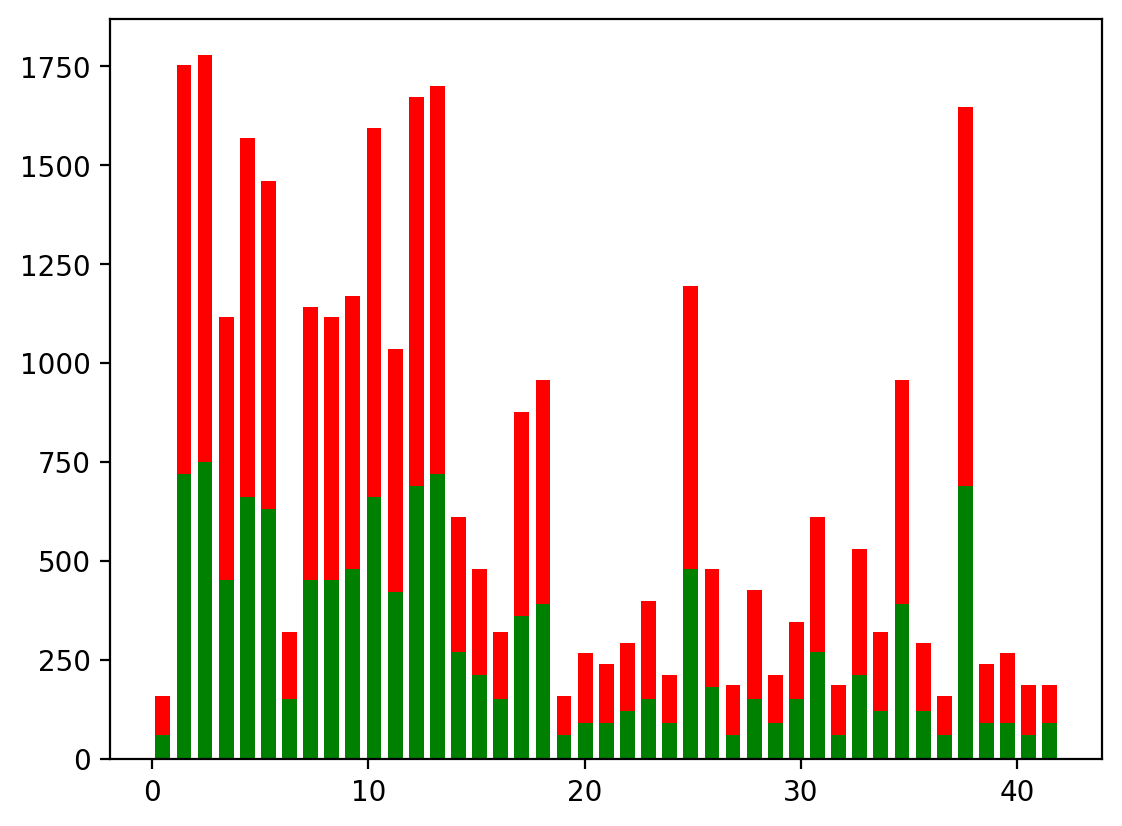

In [8]:
#verificam distributia classelor diferite
train_hist,train_bins=np.histogram(y_train,bins=num_classes)
test_hist,test_bins=np.histogram(y_test,bins=num_classes)
train_width=0.7*(train_bins[1]-train_bins[0])
train_center=(train_bins[:-1]+train_bins[1:])/2
test_width=0.7*(test_bins[1]-test_bins[0])
test_center=(test_bins[:-1]+test_bins[1:])/2
plt.bar(train_center,train_hist,align='center',color='red',width=train_width)
plt.bar(test_center,test_hist,align='center',color='green',width=test_width)
plt.show()

In [9]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train=X_train/255
X_test=X_test/255
print('X_train shape:',X_train.shape)
print(X_train.shape[0],'train samples')
print(X_test.shape[0],'test samples')

X_train shape: (30799, 32, 32, 3)
30799 train samples
12630 test samples


In [10]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)

In [11]:
if K.image_data_format()=='channels_first':
  input_shape=(1,image_rows,image_cols)
else:
  input_shape=(image_rows,image_cols,1)

In [30]:
#Cream arhitectura de retea neuronala
model=Sequential()
model.add(Conv2D(16,(3,3),input_shape=(32,32,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(50,(5,5),padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dense(50))
model.add(Activation("relu"))
model.add(Dense(300))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [33]:
los=keras.losses.Poisson(reduction="sum_over_batch_size", name="poisson")
model.compile(loss=los,optimizer='Adam',metrics=['accuracy'])

In [36]:
theLeNet=model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
121/121 [==============================] - 1s 8ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0383 - val_accuracy: 0.9328
Epoch 2/10
121/121 [==============================] - 1s 8ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9329
Epoch 3/10
121/121 [==============================] - 1s 8ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9327
Epoch 4/10
121/121 [==============================] - 1s 8ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9327
Epoch 5/10
121/121 [==============================] - 1s 7ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0385 - val_accuracy: 0.9327
Epoch 6/10
121/121 [==============================] - 1s 7ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0385 - val_accuracy: 0.9327
Epoch 7/10
121/121 [==============================] - 1s 8ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 0.9327
Epoch 